In [2]:
from astropy.table import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from astropy.table import hstack
import os
import seaborn as sns
from scipy.stats import binned_statistic
import matplotlib
import matplotlib.backends.backend_pdf
from scipy.stats import chi2, binned_statistic
from astropy.cosmology import Planck13
import pickle

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=18), plt.rc('ytick', labelsize=18)
plt.rcParams['savefig.dpi'] = 300
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)

In [3]:
dev_path = '/Users/lejay/research/lephare_dev/my_code/'
output_dir = dev_path+'output_cats/'
graham_output_dir = dev_path + 'graham_output_cats/'

#### load in catalogs

In [4]:
# the output catalogs in COSMOS (from graham)
name_tag = '_08squdeg'
detect_limit = '_nolimit'
nz_prior = '_nz_prior'
# nz_prior = ''
cat_output_no_irac_nir_mass_name = graham_output_dir+'cat_out'+name_tag+'_nonirirac_il'+nz_prior+detect_limit+'_formass.fits'
cat_output_no_irac_mass_name = graham_output_dir+'cat_out'+name_tag+'_noirac_il'+nz_prior+detect_limit+'_formass.fits'
cat_output_no_nir_mass_name = graham_output_dir+'cat_out'+name_tag+'_nonir_il'+nz_prior+detect_limit+'_formass.fits'
cat_output_full_mass_name = graham_output_dir+'cat_out'+name_tag+'_allphot_il'+nz_prior+detect_limit+'_formass.fits'
cat_names = [cat_output_no_irac_nir_mass_name, cat_output_no_irac_mass_name, cat_output_no_nir_mass_name, cat_output_full_mass_name]
filter_selections = ['optical only','no irac / with nir','no nir / with irac','full photometry']

#### Binary Selection

##### useful functions
Holden et al. 2012

fractional scores (cost functions):\
$s_{sf}=f_c +rf_m - |f_c-rf_m|$\
$s_{q}=rf_c +f_m - |rf_c-f_m|$

where $r$ is the factor to emphasize contamination fraction in quiescent sample and missing fraciton in sf sample

In [5]:
def gv_boundary_2(color1, ic_1, ic_2, slope):
    nuv_1 = ic_1
    nuv_2 = slope*color1 + ic_2
    return np.maximum(nuv_1, nuv_2)

def fraction_score(cat,ic_1, ic_2,slope, diagram_type='NUVrK',eval_type='q',verbose=False, factor=3.5):
    if diagram_type=='NUVrK':
        color1 = cat['MAG_ABS_r'] - cat['MAG_ABS_Ks']
    elif diagram_type=='NUVrz':
        color1 = cat['MAG_ABS_r'] - cat['MAG_ABS_z']
    elif diagram_type=='NUVrJ':
        color1 = cat['MAG_ABS_r'] - cat['MAG_ABS_J']
    else:
        return 1
    
    delta_gv = cat['MAG_ABS_NUV'] - cat['MAG_ABS_r'] - gv_boundary_2(color1, ic_1, ic_2, slope)
    q = delta_gv > 0
    sf = delta_gv < 0
    true_q = cat['CLASS']==0 
    true_sf = cat['CLASS']!=0
    
    if eval_type=='q':
        FP = sum(true_sf*q)  # false positive
        TP = sum(true_q*q)   # true positive
        FN = sum(true_q*sf)  # false negative
        TN = sum(true_sf*sf) # true negative
    else:
        FP = sum(true_q*sf)  # false positive
        TP = sum(true_sf*sf)   # true positive
        FN = sum(true_sf*q)  # false negative
        TN = sum(true_q*q) # true negative
    if verbose:
        print('confusion matrix',FP,TP,FN,TN)
        
    if TP+FP>0:
        fc = FP/(TP+FP)
    else:
        fc=0.99
    
    if TP+FN>0:
        fm = FN/(TP+FN)
    else:
        fm=0.99
    
    # original formula from Holden et al. 2012
    if eval_type =='sf':
        return fc, fm, fc + factor*fm + abs(fc-factor*fm)
    else:
        return fc, fm, factor*fc + fm + abs(factor*fc-fm)

In [6]:
# binary selection box parameter search grid
ic_1_list = np.linspace(3.0, 4.5, 10)  #8,18,18
ic_2_list = np.linspace(1.0, 5.0, 20)
slope_list = np.linspace(1.5, 4.5, 20)
# ic_1_list = np.linspace(3.5, 4.5, 5)  #8,18,18
# ic_2_list = np.linspace(1.0, 6.0, 18)
# slope_list = np.linspace(0.5, 3.5, 20)
ic_1_mesh, ic_2_mesh, slope_mesh = np.meshgrid(ic_1_list, ic_2_list, slope_list, indexing='ij')
print('search grid size:',len(ic_1_mesh.ravel()))

# grid for fixed slope (fs = fixed slope)
ic_fs_1_list = np.linspace(3.5, 4.5, 15)
ic_fs_2_list = np.linspace(1.0, 3.0, 30)
ic_fs_1_mesh, ic_fs_2_mesh = np.meshgrid(ic_fs_1_list, ic_fs_2_list, indexing='ij')
slope_fs = 2.0
print('search grid size:',len(ic_fs_1_mesh.ravel()))

search grid size: 4000
search grid size: 450


##### find the selection box


In [7]:
# the output catalogs (from graham)
name_tag = '_08squdeg'
detect_limit = '_nolimit'
nz_prior = '_nz_prior'
sfq_added = '_sfq_added'
pcat_output_nonir_name = graham_output_dir+'pcat_cat_out'+name_tag+'_nonir_il'+nz_prior+detect_limit+'_formass'+sfq_added+'.fits'
print(pcat_output_nonir_name)

/Users/lejay/research/lephare_dev/my_code/graham_output_cats/pcat_cat_out_08squdeg_nonir_il_nz_prior_nolimit_formass_sfq_added.fits


In [ ]:
# optimize the selection box
best_box = []
scores_arr = []
sample_size = 1000
diagram_type = 'NUVrK'

# gal_sample = 'all' # all or massive
# cat_names = [cat_output_no_irac_nir_mass_name]
#zkeyname='Z_ML'

# gal_sample = 'v9pcat'
# cat_names = [graham_output_dir+'v9pcat_COSMOS_deep_nomaglimit_nonir_nz_prior_.fits']
# zkeyname='Z_COM' # combined phos cat redshift and my redshift

gal_sample = 'pcat'
cat_names = [pcat_output_nonir_name.replace('_sfq_added.fits','c20added.fits')]
zkeyname='Z_COMBINE' # combined phos cat redshift and my redshift

fit_type = 'free' # free, fix_slope, or evolving
# r_factors = [10,3.5,2.5,1.5]
r_factors = [10,3.5,2.5,1.5]

z_mins = np.array([0.2, 0.5, 0.8, 1.1])
z_maxs = np.array([0.5, 0.8, 1.1, 1.5])
z_centers = (z_mins+z_maxs)/2
tl_list = Planck13.lookback_time(z_centers).value

mass_split = 'split'
if mass_split == 'split':
    mass_cut = 10.3
    mass_lows = [8.0,mass_cut]
    mass_highs = [mass_cut,12.5]
    mass_idx = 0
    mass_low = mass_lows[mass_idx]
    mass_high = mass_highs[mass_idx]
    mass_split_show = '_'+str(mass_low)+'_'+str(mass_high)
else:
    mass_low = 8.0
    mass_high = 12.5
    mass_split_show = ''

print('mass range',mass_low, mass_high)
for cat_name in cat_names:
    cat = Table.read(cat_name)
    cat = cat[(cat['lp_zPDF']>0) & (cat['lp_zPDF']<3)]
    for z_idx in range(len(z_mins)):
        print(str(z_mins[z_idx])+'<z<'+str(z_maxs[z_idx]))
        
        # cut in redshift bin
        cat_z = cat[(cat[zkeyname]>z_mins[z_idx]) & (cat[zkeyname]<z_maxs[z_idx])]
        
        # sf_weight
        sf_weight = len(cat_z[cat_z['CLASS']==0])/len(cat_z[cat_z['CLASS']==1]) 
        #sf_weight = 0
        
        # quality flags and photometric flags
        flag_photoz = cat_z['flag_photoz']==1  
        flag_optical = cat_z['flag_optical'] 
        flag_irac = cat_z['flag_irac'] 
        flag_nir = cat_z['flag_nir'] 
        if '_nonirirac_' in cat_name:
            cond_filters = (flag_optical>3)
            phot_config = 'nonirirac'
        elif '_nonir_' in cat_name:
            cond_filters = (flag_optical>3) & (flag_irac>=1)
            phot_config = 'nonir'
        elif '_noirac_' in cat_name:
            cond_filters = (flag_optical>3) & (flag_nir>=1)
            phot_config = 'noirac'
        else:
            cond_filters = (flag_optical>3) & (flag_irac>=1) & (flag_nir>=1)
            phot_config = 'allphot'
        cat_z = cat_z[flag_photoz & cond_filters]   
        
        # mass cut
        if gal_sample != 'massive':
            cat_z = cat_z[cat_z['MASS_MED_massrun']>mass_low]
            cat_z = cat_z[cat_z['MASS_MED_massrun']<mass_high]
            print(len(cat_z),mass_low, mass_high)
            if len(cat_z)>=sample_size:
                select_ids = np.random.choice(np.arange(len(cat_z)), size=sample_size,replace=False)
                cat_z = cat_z[select_ids]
            
        else:
            cat_z = cat_z[cat_z['MASS_MED_massrun']>11.2]

        scores = []
        if fit_type == 'free':
            for k in tqdm(range(len(ic_1_mesh.ravel()))):
                fc_sf, fm_sf, score_sf = fraction_score(cat_z, ic_1_mesh.ravel()[k], ic_2_mesh.ravel()[k], slope_mesh.ravel()[k], diagram_type=diagram_type, eval_type='sf',factor=r_factors[z_idx])
                fc_q, fm_q, score_q = fraction_score(cat_z, ic_1_mesh.ravel()[k], ic_2_mesh.ravel()[k], slope_mesh.ravel()[k], diagram_type=diagram_type, eval_type='q',factor=r_factors[z_idx])
                if score_sf >= 0 and score_q>0: 
                    scores.append(sf_weight*score_sf + (1-sf_weight)*score_q)
                    #print(ic_1_mesh.ravel()[k], ic_2_mesh.ravel()[k], slope_mesh.ravel()[k],sf_weight*score_sf + (1-sf_weight)*score_q)
                else:
                    scores.append(99.)
            best_id = np.argmin(np.array(scores))
            ic_1,ic_2,slope = ic_1_mesh.ravel()[best_id], ic_2_mesh.ravel()[best_id], slope_mesh.ravel()[best_id]
            
        elif fit_type == 'fix_slope':
            for k in tqdm(range(len(ic_fs_1_mesh.ravel()))):
                fc_sf, fm_sf, score_sf = fraction_score(cat_z, ic_fs_1_mesh.ravel()[k], ic_fs_2_mesh.ravel()[k], slope_fs, diagram_type=diagram_type, eval_type='sf')
                fc_q, fm_q, score_q = fraction_score(cat_z, ic_fs_1_mesh.ravel()[k], ic_fs_2_mesh.ravel()[k], slope_fs, diagram_type=diagram_type, eval_type='q')
                if score_sf >= 0 and score_q>0: 
                    scores.append(sf_weight*score_sf + (1-sf_weight)*score_q)
                else:
                    scores.append(99.)
            best_id = np.argmin(np.array(scores))
            ic_1,ic_2,slope = ic_fs_1_mesh.ravel()[best_id], ic_fs_2_mesh.ravel()[best_id], slope_fs
            
        else:
            best_box_lowz = np.load('best_select_box_lepharecheck_'+diagram_type+'_'+phot_config+'_free.npy')[0]
            ic_1_lowz, ic_2_lowz, slope_lowz = best_box_lowz[0],best_box_lowz[1],best_box_lowz[2]
            ic_2 = ic_2_lowz - 0.029*(tl_list[z_idx]-tl_list[0])
            ic_1 = ic_2 + 1.004
            slope = slope_lowz
            scores.append(0)
        
        if (z_idx ==0 or z_idx==1):
            best_box.append([ic_1,ic_2,slope])
        else:
            best_box.append([ic_1,ic_2,slope])
        scores_arr.append(scores)
        print('best selection box:',[round(ic_1,3),round(ic_2,3),round(slope,3)],'best score:',round(np.min(scores),4),'avg. score:',round(np.mean(scores),4),'median score:',round(np.median(scores),4),'\n')
        
        delta_gv = cat_z['MAG_ABS_NUV'] - cat_z['MAG_ABS_r'] - gv_boundary_2(cat_z['MAG_ABS_r'] - cat_z['MAG_ABS_Ks'], ic_1, ic_2, slope)
        q = delta_gv[delta_gv > 0]
        sf = delta_gv[delta_gv < 0]
        print('sf-gals:',len(sf),'q-gals:',len(q))
    
    np.save('best_select_box_lepharecheck_'+diagram_type+'_'+phot_config+'_'+fit_type+mass_split_show+'.npy',np.array(best_box))
    np.save('scores_lepharecheck_'+diagram_type+'_'+phot_config+'_'+fit_type+mass_split_show+'.npy',np.array(scores_arr))

mass range 8.0 10.3
0.2<z<0.5


  0%|          | 1/4000 [00:00<09:04,  7.35it/s]

1743 8.0 10.3


100%|██████████| 4000/4000 [08:55<00:00,  7.47it/s]


best selection box: [3.5, 1.421, 2.605] best score: 0.6167 avg. score: 7.0263 median score: 1.7407 

sf-gals: 898 q-gals: 102
0.5<z<0.8


  0%|          | 1/4000 [00:00<10:15,  6.50it/s]

1908 8.0 10.3


 52%|█████▏    | 2071/4000 [05:07<04:31,  7.12it/s]

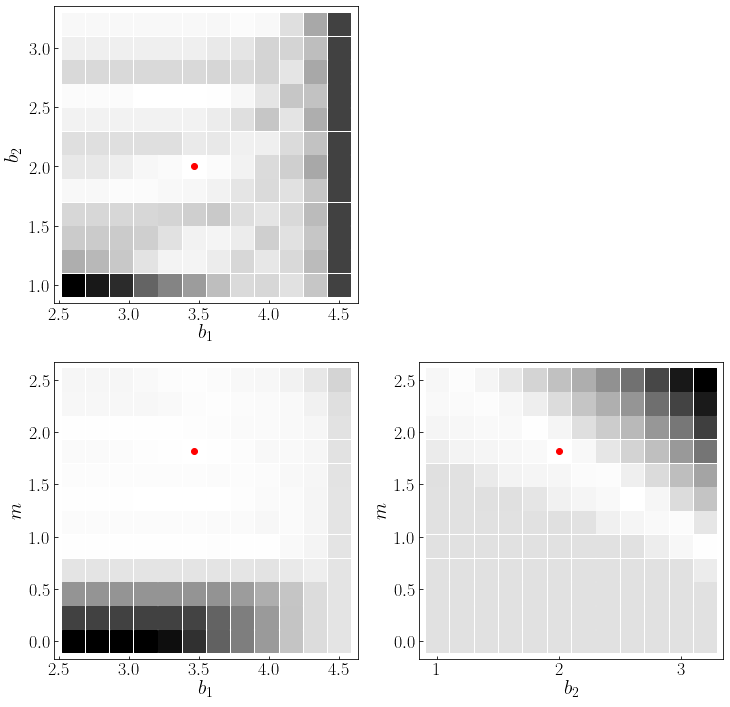

In [155]:
# plot score map
fig, axs = plt.subplots(2, 2, figsize = (12,12))
phot_type = 'nonir'
scores = np.load('scores_lepharecheck_'+diagram_type+'_'+phot_config+'_'+fit_type+'.npy')[2].reshape(12,12,12)
best_box = np.load('best_select_box_lepharecheck_'+diagram_type+'_'+phot_config+'_'+fit_type+'.npy')[2]

#[ic_1,ic_2,m]
ic_1_mesh2, ic_2_mesh2 = np.meshgrid(ic_1_list, ic_2_list, indexing='ij')
scores_mar = scores.min(axis=2) # marginalized
axs[0][0].scatter(ic_1_mesh2.ravel(),ic_2_mesh2.ravel(),s=500,marker='s',c=scores_mar.ravel(),cmap='Greys')
axs[0][0].scatter(best_box[0],best_box[1],c='r')
axs[0][0].set_xlabel('$b_1$',fontsize=20)
axs[0][0].set_ylabel('$b_2$',fontsize=20)

ic_1_mesh2, slope_mesh2 = np.meshgrid(ic_1_list, slope_list, indexing='ij')
scores_mar = scores.min(axis=1) # marginalized
axs[1][0].scatter(ic_1_mesh2.ravel(),slope_mesh2.ravel(),s=500,marker='s',c=scores_mar.ravel(),cmap='Greys')
axs[1][0].scatter(best_box[0],best_box[2],c='r')
axs[1][0].set_xlabel('$b_1$',fontsize=20)
axs[1][0].set_ylabel('$m$',fontsize=20)

ic_2_mesh2, slope_mesh2 = np.meshgrid(ic_2_list, slope_list, indexing='ij')
scores_mar = scores.min(axis=0) # marginalized
axs[1][1].scatter(ic_2_mesh2.ravel(),slope_mesh2.ravel(),s=500,marker='s',c=scores_mar.ravel(),cmap='Greys')
axs[1][1].scatter(best_box[1],best_box[2],c='r')
axs[1][1].set_xlabel('$b_2$',fontsize=20)
axs[1][1].set_ylabel('$m$',fontsize=20)

fig.delaxes(axs[0][1])

#### SVM classifier 

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

In [38]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,0]
    Z = Z.reshape(xx.shape)
    out = ax.contour(xx, yy, Z, **params)
    return out

In [53]:
# cat_names = [cat_output_no_irac_nir_mass_name, cat_output_no_irac_mass_name, cat_output_no_nir_mass_name, cat_output_full_mass_name]
cat_name = cat_output_no_nir_mass_name
gal_sample = 'all' # all or massive
diagram_type = 'NUVrK'
print(cat_name+'\n')

z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
# z_mins = [0.2]
# z_maxs = [1.5]

mass_split = ''
if mass_split == 'split':
    mass_lows = [7.0,9.0,10.0,11.0]
    mass_highs = [9.0,10.0,11.0,12.5]
    mass_idx = 1
    mass_low = mass_lows[mass_idx]
    mass_high = mass_highs[mass_idx]
    mass_split_show = '_'+str(mass_low)+'_'+str(mass_high)
else:
    mass_low = 7.0
    mass_high = 12.5
    mass_split_show = ''

for z_idx in range(len(z_mins)):
    print(str(z_mins[z_idx])+'<z<'+str(z_maxs[z_idx]))
    cat = Table.read(cat_name.replace('.fits','c20added.fits'))
    
    # cut in redshift bin
    cat = cat[(cat['lp_zPDF']>0) & (cat['lp_zPDF']<1.5)]
    cat = cat[(cat['Z_ML']>z_mins[z_idx]) & (cat['Z_ML']<z_maxs[z_idx])]
    
    # quality flags and photometric flags
    flag_photoz = cat['flag_photoz']==1  
    flag_optical = cat['flag_optical'] 
    flag_irac = cat['flag_irac'] 
    flag_nir = cat['flag_nir'] 
    if '_nonirirac_' in cat_name:
        cond_filters = (flag_optical>4)
        phot_config = 'nonirirac'
    elif '_nonir_' in cat_name:
        cond_filters = (flag_optical>4) & (flag_irac>=1)
        phot_config = 'nonir'
    elif '_noirac_' in cat_name:
        cond_filters = (flag_optical>4) & (flag_nir>=1)
        phot_config = 'noirac'
    else:
        cond_filters = (flag_optical>4) & (flag_irac>=1) & (flag_nir>=1)
        phot_config = 'allphot'
    cat = cat[flag_photoz & cond_filters]
    
    if gal_sample == 'all':
        select_ids = np.random.choice(np.arange(len(cat)), size=100,replace=False)
        cat = cat[select_ids]
    else:
        cat = cat[cat['MASS_MED_massrun']>11.2]
    
    cat = cat['lp_zPDF','MAG_ABS_NUV','MAG_ABS_r','MAG_ABS_J','MAG_ABS_Ks','CLASS']
    
    if diagram_type == 'NUVrK':
        x=np.c_[np.array(cat['MAG_ABS_r']-cat['MAG_ABS_Ks']),np.array(cat['MAG_ABS_NUV']-cat['MAG_ABS_r'])]  # nuv r k colors as inputs
        y=cat['CLASS']==0  
    elif diagram_type == 'NUVrJ':
        x=np.c_[np.array(cat['MAG_ABS_r']-cat['MAG_ABS_J']),np.array(cat['MAG_ABS_NUV']-cat['MAG_ABS_r'])]  # nuv r k colors as inputs
        y=cat['CLASS']==0  
        
    svm_cv=GridSearchCV(svm.SVC(kernel='rbf'),{'gamma': np.linspace(0.1, 0.3, 50), 'C' : np.linspace(0.02,0.5,50)}, 
                    scoring={'AUC': 'roc_auc'}, refit='AUC', cv = 5, return_train_score=True)
    
    svm_cv.fit(x,y)
    gamma = svm_cv.best_params_['gamma']
    C = svm_cv.best_params_['C']
    print('gamma=%.3f, C=%.3f, mean AUC of best model: %.3f' % (gamma,C,svm_cv.best_score_))
    
    # train the SVM model
    clf = svm.SVC(kernel='rbf', gamma=gamma, C=C,  probability=True,verbose=True)   # the svm classifier
    clf.fit(x, y)

    #save the SVM estimator through pickle
    pkl_filename = 'pickle_svm_'+phot_config+'_'+diagram_type+'_'+str(z_mins[z_idx])+'_'+str(z_maxs[z_idx])+mass_split_show+'.pkl'
    with open(pkl_filename, 'wb') as file:
        pickle.dump(clf, file)

/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_08squdeg_nonir_il_nz_prior_nolimit_formass.fits

0.2<z<0.5
gamma=0.100, C=0.020, mean AUC of best model: 1.000
[LibSVM]0.5<z<0.8
gamma=0.165, C=0.020, mean AUC of best model: 0.997
[LibSVM]0.8<z<1.1
gamma=0.108, C=0.020, mean AUC of best model: 0.968
[LibSVM]1.1<z<1.5
gamma=0.190, C=0.294, mean AUC of best model: 0.967
[LibSVM]

#### Diagrams

In [40]:
from texttable import *
import latextable

                | $f_{c,sf}$ | $f_{m,sf}$ | $f_{c,q}$ | $f_{m,q}$
================+============+============+===========+==========
    Optical     |   1.6\%    |   2.8\%    |  27.8\%   |  15.6\%  
  Optical+NIR   |   1.8\%    |   1.9\%    |  20.0\%   |  19.4\%  
 Optical+IRAC   |   4.3\%    |   4.7\%    |  14.3\%   |  12.9\%  
Full Photometry |   4.5\%    |   3.6\%    |  11.6\%   |  14.7\%  
\begin{table}
	\begin{center}
		\begin{tabular}{c|c|c|c|c}
			  & $f_{c,sf}$ & $f_{m,sf}$ & $f_{c,q}$ & $f_{m,q}$ \\
			\hline
			Optical & 1.6\% & 2.8\% & 27.8\% & 15.6\% \\
			Optical+NIR & 1.8\% & 1.9\% & 20.0\% & 19.4\% \\
			Optical+IRAC & 4.3\% & 4.7\% & 14.3\% & 12.9\% \\
			Full Photometry & 4.5\% & 3.6\% & 11.6\% & 14.7\% \\
		\end{tabular}
	\end{center}
	\caption{Contamintion and Missing Fraction.}
\end{table}
                | $f_{c,sf}$ | $f_{m,sf}$ | $f_{c,q}$ | $f_{m,q}$
================+============+============+===========+==========
    Optical     |   10.0\%   |   29.1\%   |  25.

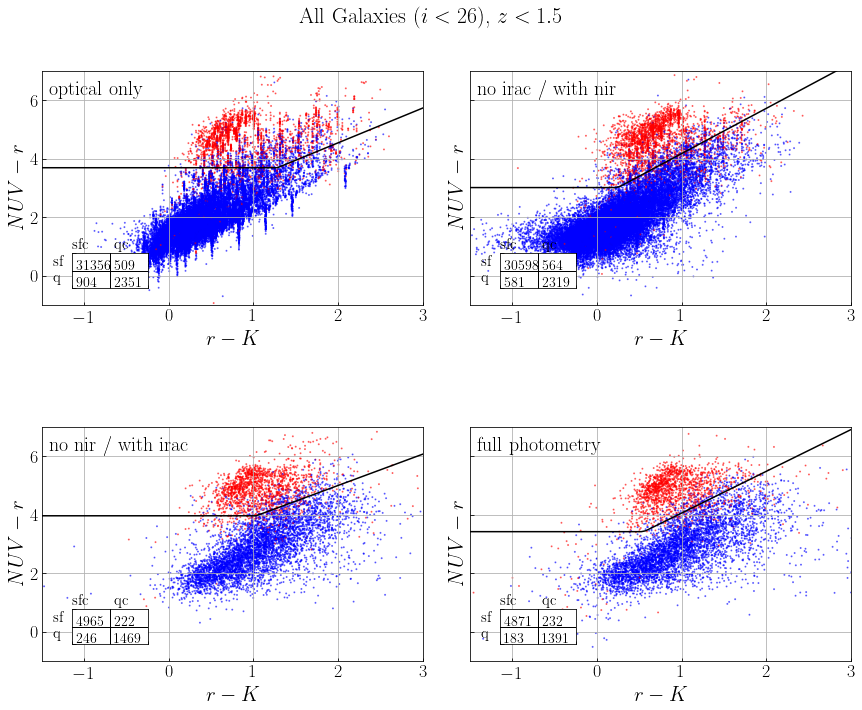

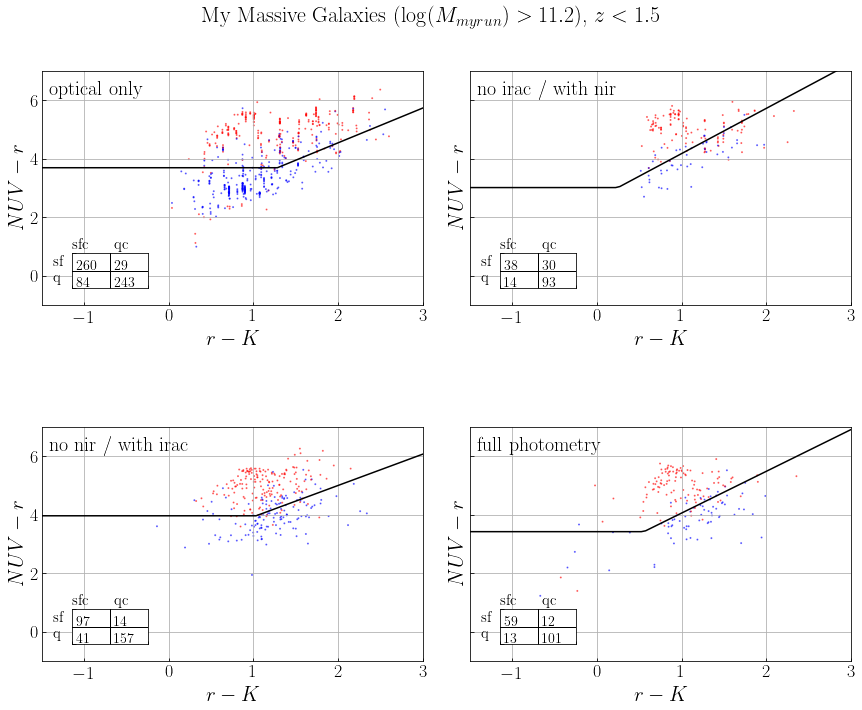

In [184]:
massive_cut=11.2
diagram_type = 'NUVrK'
pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/lejay/Desktop/lephare_'+diagram_type+'.pdf')
zmax=1.5

cat_types = ['Optical','Optical+NIR','Optical+IRAC','Full Photometry']
for selection in ['all','massive']:
    tab_rows = [[' ','$f_{c,sf}$','$f_{m,sf}$','$f_{c,q}$','$f_{m,q}$']]
    fig, axs = plt.subplots(2, 2, figsize = (14, 11), sharey=True)
    for i,cat_name in enumerate(cat_names):
        row = i // 2; col = i % 2
        cat_output_c20added = Table.read(cat_name.replace('.fits','c20added.fits'))
        cat_output_c20added = cat_output_c20added[(cat_output_c20added['lp_zPDF']>0) & (cat_output_c20added['lp_zPDF']<zmax)]

        # select subsample
        flag_photoz = (cat_output_c20added['flag_photoz']==1)
        if selection == 'all':
            cond = np.ones(len(cat_output_c20added)).astype(bool)
            fig_title = 'All Galaxies ($i<26$)'
        elif selection == 'massive':
            cond = (cat_output_c20added['MASS_MED_massrun']>massive_cut)
            fig_title = 'My Massive Galaxies ($\log(M_{myrun})>'+str(massive_cut)+'$)'
        else:
            raise NameError('wrong name')
        
        
        flag_optical = cat_output_c20added['flag_optical'] 
        flag_irac = cat_output_c20added['flag_irac'] 
        flag_nir = cat_output_c20added['flag_nir'] 
        if '_nonirirac_' in cat_name:
            cond_filters = (flag_optical>4)
        elif '_nonir_' in cat_name:
            cond_filters = (flag_optical>4) & (flag_irac>=1)
        elif '_noirac_' in cat_name:
            cond_filters = (flag_optical>4) & (flag_nir>=1)
        else:
            cond_filters = (flag_optical>4) & (flag_irac>=1) & (flag_nir>=1)
        
        # COSMOS consistent photoz objects only
        fig_title += ', $z<'+str(zmax)+'$'
        cond = cond & flag_photoz & cond_filters
        
        # NUVrK selection box
        best_box = np.load('best_select_box_lepharecheck_'+diagram_type+'_.npy')
        rk_draw = np.linspace(-2,3,100)
        nuv_draw_mid = gv_boundary_2(rk_draw,best_box[i][0],best_box[i][1],best_box[i][2])
        axs[row][col].plot(rk_draw, nuv_draw_mid, color='k')
        
        # plot
        if diagram_type == 'NUVrK':
            im = axs[row][col].scatter(cat_output_c20added[cond]['MAG_ABS_r']-cat_output_c20added[cond]['MAG_ABS_Ks'], 
                                   cat_output_c20added[cond]['MAG_ABS_NUV']-cat_output_c20added[cond]['MAG_ABS_r'],
                                   s=1,c=cat_output_c20added[cond]['CLASS'],alpha=0.5,cmap='bwr_r')
            axs[row][col].set_xlabel(r'$r-K$',fontsize=21)
        elif diagram_type == 'NUVrJ':
            im = axs[row][col].scatter(cat_output_c20added[cond]['MAG_ABS_r']-cat_output_c20added[cond]['MAG_ABS_J'], 
                                   cat_output_c20added[cond]['MAG_ABS_NUV']-cat_output_c20added[cond]['MAG_ABS_r'],
                                   s=1,c=cat_output_c20added[cond]['CLASS'],alpha=0.5,cmap='bwr_r')
            axs[row][col].set_xlabel(r'$r-J$',fontsize=21)
        axs[row][col].set_ylabel(r'$NUV-r$',fontsize=21)
        axs[row][col].set_xlim([-1.5,3])
        axs[row][col].set_ylim([-1,7])
        axs[row][col].grid()
        axs[row][col].annotate(filter_selections[i],xy=([0.02,0.9]),xycoords='axes fraction',fontsize=20,color='k')
        
        #### contingency table / confusion matrix (inset plot 2) ######
        # q=P sf=N
        cat = cat_output_c20added[cond]
        cat_sf = cat[cat['CLASS']==1]
        cat_q = cat[cat['CLASS']==0]
        if diagram_type == 'NUVrK':
            rk_sf = np.array(cat_sf['MAG_ABS_r'] - cat_sf['MAG_ABS_Ks'])
            rk_q = np.array(cat_q['MAG_ABS_r'] - cat_q['MAG_ABS_Ks']) 
            delta_gv_sf = cat_sf['MAG_ABS_NUV'] - cat_sf['MAG_ABS_r']-gv_boundary_2(rk_sf,best_box[i][0],best_box[i][1],best_box[i][2])
            delta_gv_q = cat_q['MAG_ABS_NUV'] - cat_q['MAG_ABS_r']-gv_boundary_2(rk_q,best_box[i][0],best_box[i][1],best_box[i][2])
        elif diagram_type == 'NUVrJ':
            rj_sf = np.array(cat_sf['MAG_ABS_r'] - cat_sf['MAG_ABS_J'])
            rj_q = np.array(cat_q['MAG_ABS_r'] - cat_q['MAG_ABS_J']) 
            delta_gv_sf = cat_sf['MAG_ABS_NUV'] - cat_sf['MAG_ABS_r']-gv_boundary_2(rj_sf,best_box[i][0],best_box[i][1],best_box[i][2])
            delta_gv_q = cat_q['MAG_ABS_NUV'] - cat_q['MAG_ABS_r']-gv_boundary_2(rj_q,best_box[i][0],best_box[i][1],best_box[i][2])
        
        # Me - C20
        sf_sf = len(cat_sf[delta_gv_sf<0])  # TN
        q_q = len(cat_q[delta_gv_q>0])      # TP
        sf_q = len(cat_q[delta_gv_q<0])     # FP
        q_sf = len(cat_sf[delta_gv_sf>0])   # FN
        
        f_c_sf = sf_q / (sf_q+sf_sf)
        f_m_sf = q_sf / (sf_q+sf_sf)
        f_c_q = q_sf / (q_q+q_sf)
        f_m_q = sf_q / (q_q+q_sf)
        tab_rows.append([cat_types[i],str(round(f_c_sf*100,1))+'\%',str(round(f_m_sf*100,1))+'\%',
                         str(round(f_c_q*100,1))+'\%',str(round(f_m_q*100,1))+'\%'])
        
        # inset table
        axs[row][col].annotate('sfc',xy=([0.08,0.24]),xycoords='axes fraction',fontsize=15)
        axs[row][col].annotate('qc',xy=([0.19,0.24]),xycoords='axes fraction',fontsize=15)
        axs[row][col].annotate('sf',xy=([0.03,0.17]),xycoords='axes fraction',fontsize=15)
        axs[row][col].annotate('q',xy=([0.03,0.1]),xycoords='axes fraction',fontsize=15)
        ax_insert2 = axs[row][col].inset_axes([0.08, 0.07, 0.2, 0.15])
        ax_insert2.annotate(str(sf_sf),xy=([-0.9,0.1]),fontsize=14)
        ax_insert2.annotate(str(sf_q),xy=([0.1,0.1]),fontsize=14)
        ax_insert2.annotate(str(q_sf),xy=([-0.9,-0.9]),fontsize=14)
        ax_insert2.annotate(str(q_q),xy=([0.1,-0.9]),fontsize=14)
        ax_insert2.axvline(ymin=-1,ymax=1,x=0,color='k',linewidth=1)
        ax_insert2.axhline(xmin=-1,xmax=1,y=0,color='k',linewidth=1)
        ax_insert2.set_xlim([-1,1])
        ax_insert2.set_ylim([-1,1])
        ax_insert2.set_yticklabels([])
        ax_insert2.set_xticklabels([])
    
    #generate LaTeX format table
    table = Texttable()
    table.set_cols_align(["c"] * 5)
    table.set_deco(Texttable.HEADER | Texttable.VLINES)
    table.add_rows(tab_rows)
    print(table.draw())
    print(latextable.draw_latex(table, caption="Contamintion and Missing Fraction."))
        
    plt.suptitle(fig_title,fontsize=22)
    plt.tight_layout(pad=4, w_pad=1)
    pdf.savefig( fig )
pdf.close()

##### split redshift bins
0.2 - 0.5\
0.5 - 0.8\
0.8 - 1.1\
1.1 - 1.5

0 [4.167 2.474 1.5  ]
1 [3.667 2.474 1.5  ]
2 [3.    1.    2.289]
3 [3.    3.947 1.5  ]
0 [3.    3.316 1.658]
1 [4.5   2.053 1.974]
2 [4.    2.684 1.5  ]
3 [3.5   2.263 1.816]


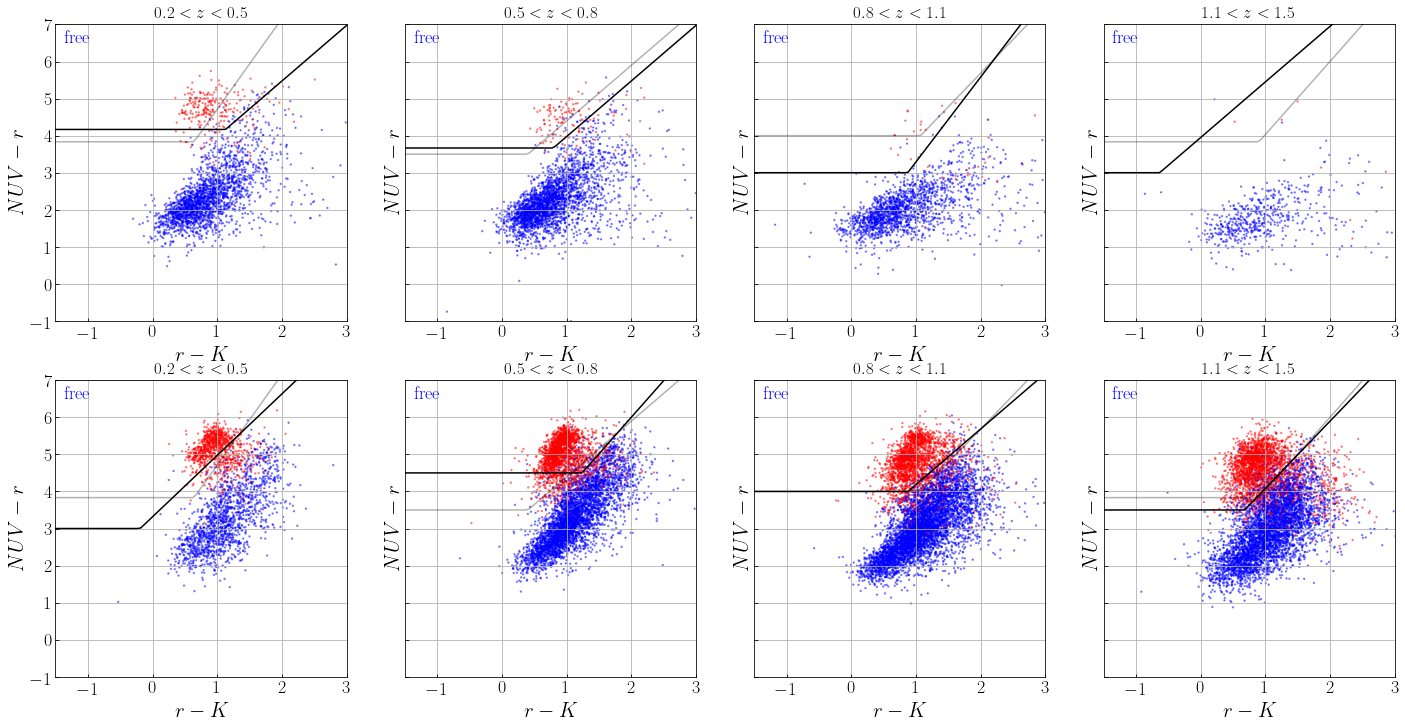

In [23]:
massive_cut=10.0
mass_lows = [8.0, massive_cut]
mass_highs = [massive_cut, 12.5]

diagram_type = 'NUVrK'
phot_config = 'nonir'
fit_type='free'
massbin_type = 'splitbin' # 'onebin' or 'splitbin'

if massbin_type == 'onebin':
    selections_rotation = ['overall','massive']
elif massbin_type == 'splitbin':
    selections_rotation = ['low-mass','massive']
else:
    raise ValueError()
    
fc_list_overall = [] # contatnimate fraction
fm_list_overall = [] # missed fraction
fc_list_massive = [] # contatnimate fraction
fm_list_massive = [] # missed fraction
z_mins = np.array([0.2, 0.5, 0.8, 1.1])
z_maxs = np.array([0.5, 0.8, 1.1, 1.5])

# catalog name
# cat_name = cat_output_no_irac_nir_mass_name
cat_name = graham_output_dir+'pcat_COSMOS_deep_nomaglimit_'+phot_config+'_nz_prior_.fits'
cat_output_c20added = Table.read(cat_name.replace('.fits','c20added.fits'))

fig, axs = plt.subplots(2, 4, figsize = (24, 12), sharey=True)
for row,selection in enumerate(selections_rotation):
    for z_idx,zmin in enumerate(z_mins):
        cat_output_c20added_z = cat_output_c20added[(cat_output_c20added['Z_ML']>zmin) & (cat_output_c20added['Z_ML']<z_maxs[z_idx])]
        
        # COSMOS consistent photoz objects only
        mass_split_show = '_'+str(mass_lows[row])+'_'+str(mass_highs[row])
        if selection=='massive' and massbin_type=='splitbin':
            cond = (cat_output_c20added_z['MASS_MED_massrun']>massive_cut)
            best_box = np.load('best_select_box_lepharecheck_'+diagram_type+'_'+phot_config+'_'+fit_type+mass_split_show+'.npy')[z_idx]
        elif selection=='low-mass':
            cond = (cat_output_c20added_z['MASS_MED_massrun']<massive_cut)
            best_box = np.load('best_select_box_lepharecheck_'+diagram_type+'_'+phot_config+'_'+fit_type+mass_split_show+'.npy')[z_idx]
        else:
            cond = np.ones(len(cat_output_c20added_z)).astype(bool)
            best_box = np.load('best_select_box_lepharecheck_'+diagram_type+'_'+phot_config+'_'+fit_type+'.npy')[z_idx]
            
        # NUVrK(J) selection box  best_select_box_lepharecheck_'+diagram_type+'_'+phot_config+'_'+fit_type+'.npy'
        print(z_idx, best_box)
        rk_draw = np.linspace(-2,3,100)
        nuv_draw_mid = gv_boundary_2(rk_draw,best_box[0],best_box[1],best_box[2])
        axs[row][z_idx].plot(rk_draw, nuv_draw_mid, color='k')
        
        # plot the overall slection box
        best_box_overall = np.load('best_select_box_lepharecheck_'+diagram_type+'_'+phot_config+'_'+fit_type+'.npy')[z_idx]
        rk_draw = np.linspace(-2,3,100)
        nuv_draw_mid = gv_boundary_2(rk_draw,best_box_overall [0],best_box_overall [1],best_box_overall [2])
        axs[row][z_idx].plot(rk_draw, nuv_draw_mid, color='k',alpha=0.3)
        
#         best_box = np.load('best_select_box_lepharecheck_'+diagram_type+'_'+phot_config+'_old.npy')[z_idx]
#         rk_draw = np.linspace(-2,3,100)
#         nuv_draw_mid = gv_boundary_2(rk_draw,best_box[0],best_box[1],best_box[2])
#         axs[row][z_idx].plot(rk_draw, nuv_draw_mid, color='k',ls='--')

        # other cuts
        flag_photoz = (cat_output_c20added_z['flag_photoz']==1)
        flag_optical = cat_output_c20added_z['flag_optical'] 
        flag_irac = cat_output_c20added_z['flag_irac'] 
        cond_filters = (flag_optical>2) & (flag_irac>=1)
        cond = cond & flag_photoz & cond_filters
        
        # plot data points
        if diagram_type == 'NUVrK':
            im = axs[row][z_idx].scatter(cat_output_c20added_z[cond]['MAG_ABS_r']-cat_output_c20added_z[cond]['MAG_ABS_Ks'], 
                                       cat_output_c20added_z[cond]['MAG_ABS_NUV']-cat_output_c20added_z[cond]['MAG_ABS_r'],
                                       s=2,c=cat_output_c20added_z[cond]['CLASS'],alpha=0.4,cmap='bwr_r')
            axs[row][z_idx].set_xlabel(r'$r-K$',fontsize=21)
        elif diagram_type == 'NUVrJ':
            im = axs[row][z_idx].scatter(cat_output_c20added_z[cond]['MAG_ABS_r']-cat_output_c20added_z[cond]['MAG_ABS_J'], 
                                       cat_output_c20added_z[cond]['MAG_ABS_NUV']-cat_output_c20added_z[cond]['MAG_ABS_r'],
                                       s=2,c=cat_output_c20added_z[cond]['CLASS'],alpha=0.4,cmap='bwr_r')
            axs[row][z_idx].set_xlabel(r'$r-J$',fontsize=21)
        
        axs[row][z_idx].set_ylabel(r'$NUV-r$',fontsize=21)
        axs[row][z_idx].set_xlim([-1.5,3])
        axs[row][z_idx].set_ylim([-1,7])
        axs[row][z_idx].grid()
        axs[row][z_idx].set_title('$'+str(zmin)+'<z<'+str(z_maxs[z_idx])+'$',fontsize=17)
        axs[row][z_idx].annotate(fit_type.replace('_',' '),color='b',xy=([0.03,0.94]),xycoords='axes fraction',fontsize=18)
        
        # SVM class results
#         with open('pickle_svm_'+phot_config+'_'+diagram_type+'_'+str(z_mins[z_idx])+'_'+str(z_maxs[z_idx])+'.pkl', 'rb') as file:
#             clf_load = pickle.load(file)
            
#         xx, yy = make_meshgrid(np.linspace(-1,3,100), np.linspace(-1,7,100))
#         plot_contours(axs[row][z_idx], clf_load, xx, yy, cmap=plt.cm.coolwarm_r)
            
        #### contingency table / confusion matrix (inset plot 2) ######
        # q=P sf=N
#         cat = cat_output_c20added_z[cond]
#         cat_sf = cat[cat['CLASS']==1]
#         cat_q = cat[cat['CLASS']==0]
#         if diagram_type == 'NUVrK':
#             rk_sf = np.array(cat_sf['MAG_ABS_r'] - cat_sf['MAG_ABS_Ks'])
#             rk_q = np.array(cat_q['MAG_ABS_r'] - cat_q['MAG_ABS_Ks']) 
#             delta_gv_sf = cat_sf['MAG_ABS_NUV'] - cat_sf['MAG_ABS_r']-gv_boundary_2(rk_sf,best_box[0],best_box[1],best_box[2])
#             delta_gv_q = cat_q['MAG_ABS_NUV'] - cat_q['MAG_ABS_r']-gv_boundary_2(rk_q,best_box[0],best_box[1],best_box[2])
#         elif diagram_type == 'NUVrJ':
#             rj_sf = np.array(cat_sf['MAG_ABS_r'] - cat_sf['MAG_ABS_J'])
#             rj_q = np.array(cat_q['MAG_ABS_r'] - cat_q['MAG_ABS_J']) 
#             delta_gv_sf = cat_sf['MAG_ABS_NUV'] - cat_sf['MAG_ABS_r']-gv_boundary_2(rj_sf,best_box[0],best_box[1],best_box[2])
#             delta_gv_q = cat_q['MAG_ABS_NUV'] - cat_q['MAG_ABS_r']-gv_boundary_2(rj_q,best_box[0],best_box[1],best_box[2])
        
#         sf_sf = len(cat_sf[delta_gv_sf<0])  # TN
#         q_q = len(cat_q[delta_gv_q>0])      # TP
#         sf_q = len(cat_q[delta_gv_q<0])     # FP
#         q_sf = len(cat_sf[delta_gv_sf>0])   # FN
#         fc = sf_q/(q_q+sf_q)
#         fm = q_sf/(q_q+q_sf)
#         if selection == 'massive':
#             fc_list_massive.append(fc)
#             fm_list_massive.append(fm)
#         else:
#             fc_list_overall.append(fc)
#             fm_list_overall.append(fm)
        
#         # inset table
#         axs[row][z_idx].annotate('sfc',xy=([0.08,0.24]),xycoords='axes fraction',fontsize=15)
#         axs[row][z_idx].annotate('qc',xy=([0.19,0.24]),xycoords='axes fraction',fontsize=15)
#         axs[row][z_idx].annotate('sf',xy=([0.03,0.17]),xycoords='axes fraction',fontsize=15)
#         axs[row][z_idx].annotate('q',xy=([0.03,0.1]),xycoords='axes fraction',fontsize=15)
#         ax_insert2 = axs[row][z_idx].inset_axes([0.08, 0.07, 0.2, 0.15])
#         ax_insert2.annotate(str(sf_sf),xy=([-0.9,0.1]),fontsize=14)
#         ax_insert2.annotate(str(sf_q),xy=([0.1,0.1]),fontsize=14)
#         ax_insert2.annotate(str(q_sf),xy=([-0.9,-0.9]),fontsize=14)
#         ax_insert2.annotate(str(q_q),xy=([0.1,-0.9]),fontsize=14)
#         ax_insert2.axvline(ymin=-1,ymax=1,x=0,color='k',linewidth=1)
#         ax_insert2.axhline(xmin=-1,xmax=1,y=0,color='k',linewidth=1)
#         ax_insert2.set_xlim([-1,1])
#         ax_insert2.set_ylim([-1,1])
#         ax_insert2.set_yticklabels([])
#         ax_insert2.set_xticklabels([])

COSMOS_deep 0.2 39196.14512471655 32704.761904761905 6488.662131519274 720.4081632653061
COSMOS_deep 0.5 58159.183673469386 52493.87755102041 5664.85260770975 1568.0272108843537
COSMOS_deep 0.8 56104.08163265306 53230.15873015873 2873.6961451247166 1551.2471655328798
COSMOS_deep 1.1 42795.46485260771 39754.87528344671 3039.6825396825398 2149.6598639455783
DEEP_deep 0.2 38297.0509383378 32533.78016085791 5761.126005361931 920.3753351206434
DEEP_deep 0.5 60548.25737265415 55643.96782841823 4903.2171581769435 1780.1608579088472
DEEP_deep 0.8 49797.0509383378 47581.76943699732 2215.0134048257373 1113.4048257372654
DEEP_deep 1.1 44637.2654155496 41269.97319034852 3366.4879356568363 2315.817694369973
ELAIS_deep 0.2 32965.94594594595 26361.62162162162 6602.9729729729725 986.7567567567567
ELAIS_deep 0.5 67278.91891891892 60533.24324324324 6744.324324324324 2225.135135135135
ELAIS_deep 0.8 50514.32432432432 48323.51351351351 2190.5405405405404 1022.7027027027027
ELAIS_deep 1.1 35938.37837837838

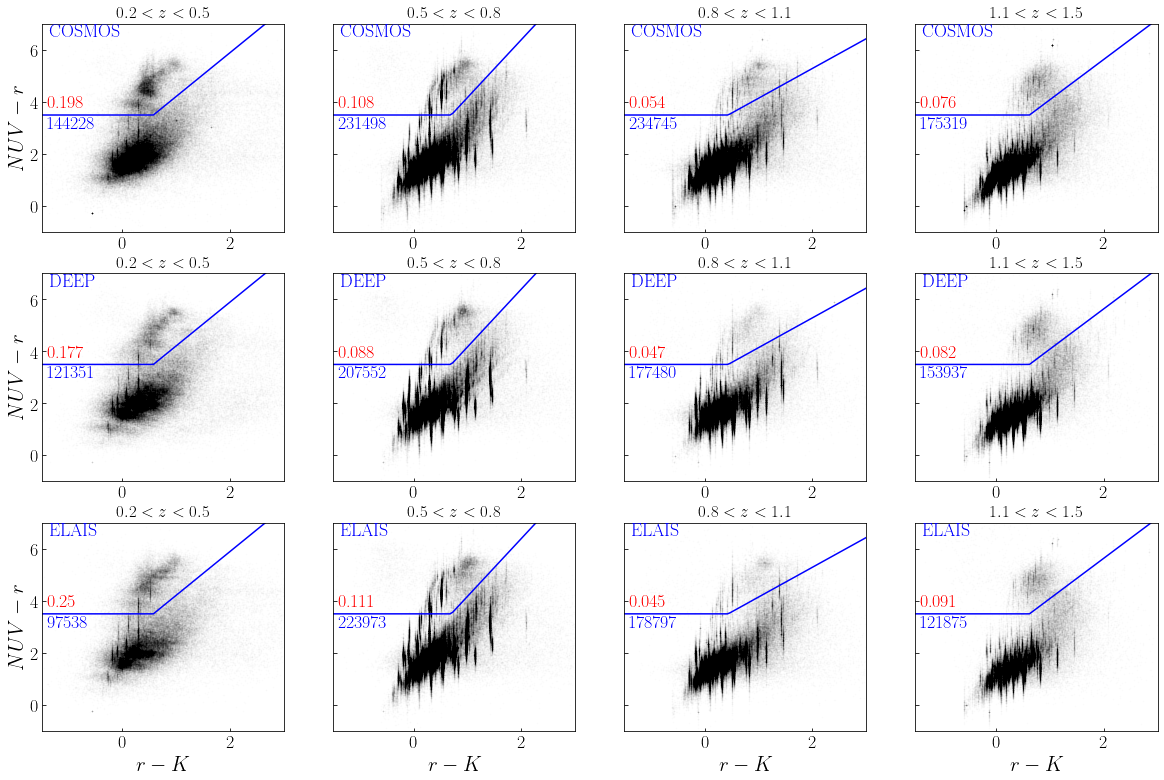

In [103]:
z_mins = np.array([0.2, 0.5, 0.8, 1.1])
z_maxs = np.array([0.5, 0.8, 1.1, 1.5])
phot_config = 'nonir'
diagram_type = 'NUVrK'
fit_type='free'
areas = [4.41, 3.73, 3.7]

fig, axs = plt.subplots(3, 4, figsize = (20, 13), sharey=True)
for cat_idx,cat_name in enumerate(['COSMOS_deep','DEEP_deep','ELAIS_deep']):
    cat_name_full = graham_output_dir+cat_name+'_cat_out_nomaglimit_'+phot_config+'_il_nz_prior_formass_sfq_added.fits'
    cat_output = Table.read(cat_name_full)
    
    cat_output = cat_output[cat_output['MASK'] == 0]  # unmasked
    cat_output = cat_output[cat_output['OBJ_TYPE'] == 0]  # galaxies
        
    for z_idx,zmin in enumerate(z_mins):
        cat_output_z = cat_output[(cat_output['Z_ML']>zmin) & (cat_output['Z_ML']<z_maxs[z_idx])]
        if diagram_type == 'NUVrK':
            im = axs[cat_idx][z_idx].scatter(cat_output_z['MAG_ABS_r']-cat_output_z['MAG_ABS_Ks'], 
                                           cat_output_z['MAG_ABS_NUV']-cat_output_z['MAG_ABS_r'],
                                           s=0.5,c='k',alpha=0.01,cmap='bwr_r')
            axs[2][z_idx].set_xlabel(r'$r-K$',fontsize=21)
            axs[cat_idx][0].set_ylabel(r'$NUV-r$',fontsize=21)
        elif diagram_type == 'NUVrJ':
            im = axs[cat_idx][z_idx].scatter(cat_output_z['MAG_ABS_r']-cat_output_z['MAG_ABS_J'], 
                                           cat_output_z['MAG_ABS_NUV']-cat_output_z['MAG_ABS_r'],
                                           s=0.5,c='k',alpha=0.01,cmap='bwr_r')
            axs[2][z_idx].set_xlabel(r'$r-J$',fontsize=21)
            axs[cat_idx][0].set_ylabel(r'$NUV-r$',fontsize=21)
            
        best_box = np.load('best_select_box_lepharecheck_'+diagram_type+'_'+phot_config+'_'+fit_type+'.npy')[z_idx]
        color1_draw = np.linspace(-2,3,100)
        nuv_draw_mid = gv_boundary_2(color1_draw,best_box[0],best_box[1],best_box[2])
        axs[cat_idx][z_idx].plot(color1_draw, nuv_draw_mid, color='b')
        
        # number of sf/q galaxies
        nuvr = cat_output_z['MAG_ABS_NUV']-cat_output_z['MAG_ABS_r']
        if diagram_type == 'NUVrK':
            color1 = cat_output_z['MAG_ABS_r'] - cat_output_z['MAG_ABS_Ks']
        else:
            color1 = cat_output_z['MAG_ABS_r'] - cat_output_z['MAG_ABS_r']
        delta_gv = nuvr - gv_boundary_2(color1,best_box[0],best_box[1],best_box[2])
        
        cat_output_z_q = cat_output_z[delta_gv>0]
        cat_output_z_sf = cat_output_z[delta_gv<0]
        ratio = len(cat_output_z_q)/len(cat_output_z_sf) 
        
        cat_output_z_q_mass = cat_output_z_q[np.logical_and(cat_output_z_q['MASS_MED_massrun']<11,cat_output_z_q['MASS_MED_massrun']>10)]
        print(cat_name, zmin, len(cat_output_z)/areas[cat_idx], len(cat_output_z_sf)/areas[cat_idx], len(cat_output_z_q)/areas[cat_idx], len(cat_output_z_q_mass)/areas[cat_idx])
        
        axs[cat_idx][z_idx].annotate(len(cat_output_z_sf),color='b',xy=([-1.4,best_box[0]-0.5]),xycoords='data',fontsize=18)
        axs[cat_idx][z_idx].annotate(round(ratio,3),color='r',xy=([-1.4,best_box[0]+0.3]),xycoords='data',fontsize=18)
        
        axs[cat_idx][z_idx].set_xlim([-1.5,3])
        axs[cat_idx][z_idx].set_ylim([-1,7])
        axs[cat_idx][z_idx].set_title('$'+str(z_mins[z_idx])+'<z<'+str(z_maxs[z_idx])+'$',fontsize=17)
        axs[cat_idx][z_idx].annotate(cat_name.replace('_deep',''),color='b',xy=([0.03,0.94]),xycoords='axes fraction',fontsize=18)
        

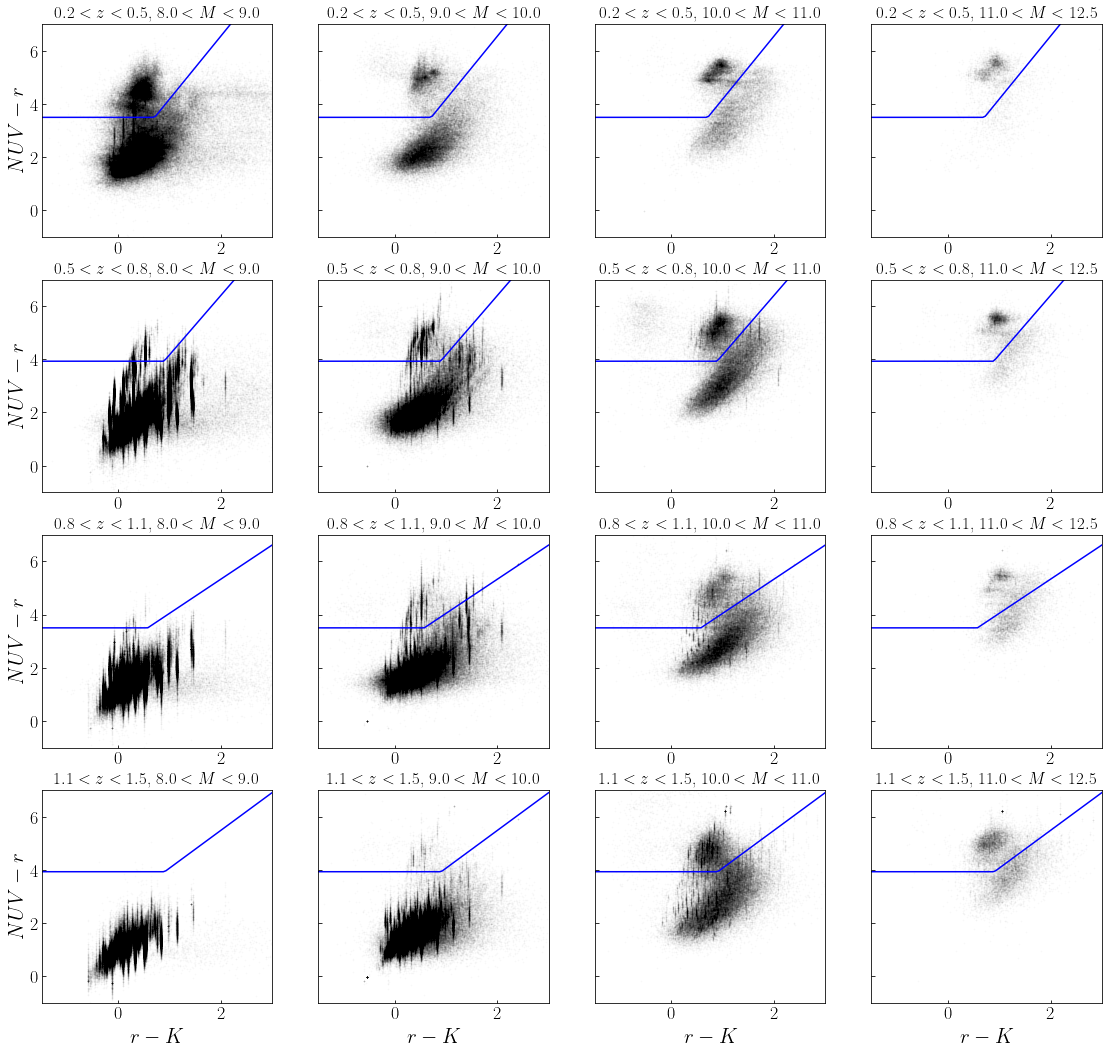

In [97]:
z_mins = np.array([0.2, 0.5, 0.8, 1.1])
z_maxs = np.array([0.5, 0.8, 1.1, 1.5])
mass_lows = [8.0,9.0,10.0,11.0]
mass_highs = [9.0,10.0,11.0,12.5]
phot_config = 'nonir'
diagram_type = 'NUVrK'
fit_type='free'

fig, axs = plt.subplots(4, 4, figsize = (19, 18), sharey=True)
for z_idx in range(len(z_mins)):
    for mass_idx in range(len(mass_lows)):
        for cat_idx,cat_name in enumerate(['COSMOS_deep','DEEP_deep','ELAIS_deep']):
            cat_name_full = graham_output_dir+cat_name+'_cat_out_nomaglimit_'+phot_config+'_il_nz_prior_formass_sfq_added.fits'
            cat_output = Table.read(cat_name_full)
            
            cat_output = cat_output[cat_output['MASK'] == 0]  # unmasked
            cat_output = cat_output[cat_output['OBJ_TYPE'] == 0]  # galaxies
            
            # z selection
            cat_output_z = cat_output[(cat_output['Z_ML']>z_mins[z_idx]) & (cat_output['Z_ML']<z_maxs[z_idx])]
            
            # mass selection 
            cat_output_zm = cat_output_z[(cat_output_z['MASS_MED_massrun']>mass_lows[mass_idx]) & (cat_output_z['MASS_MED_massrun']<mass_highs[mass_idx])]
            if diagram_type == 'NUVrK':
                im = axs[z_idx][mass_idx].scatter(cat_output_zm['MAG_ABS_r']-cat_output_zm['MAG_ABS_Ks'], 
                                               cat_output_zm['MAG_ABS_NUV']-cat_output_zm['MAG_ABS_r'],
                                               s=0.5,c='k',alpha=0.02,cmap='bwr_r')
                axs[3][mass_idx].set_xlabel(r'$r-K$',fontsize=21)
                axs[z_idx][0].set_ylabel(r'$NUV-r$',fontsize=21)
            if diagram_type == 'NUVrJ':
                im = axs[z_idx][mass_idx].scatter(cat_output_zm['MAG_ABS_r']-cat_output_zm['MAG_ABS_J'], 
                                               cat_output_zm['MAG_ABS_NUV']-cat_output_zm['MAG_ABS_r'],
                                               s=0.5,c='k',alpha=0.02,cmap='bwr_r')
                axs[3][mass_idx].set_xlabel(r'$r-J$',fontsize=21)
                axs[z_idx][0].set_ylabel(r'$NUV-r$',fontsize=21)
                
        best_box = np.load('best_select_box_lepharecheck_'+diagram_type+'_'+phot_config+'_'+fit_type+'.npy')[z_idx]
        rk_draw = np.linspace(-2,3,100)
        nuv_draw_mid = gv_boundary_2(rk_draw,best_box[0],best_box[1],best_box[2])
        axs[z_idx][mass_idx].plot(rk_draw, nuv_draw_mid, color='b')
            
        axs[z_idx][mass_idx].set_xlim([-1.5,3])
        axs[z_idx][mass_idx].set_ylim([-1,7])
        axs[z_idx][mass_idx].set_title('$'+str(z_mins[z_idx])+'<z<'+str(z_maxs[z_idx])+'$, '+'$'+str(mass_lows[mass_idx])+'<M<'+str(mass_highs[mass_idx])+'$',fontsize=17)

0.2 0.5 7.0 10.2 1174 175
0.2 0.5 10.2 12.5 469 286
0.5 0.8 7.0 10.2 1712 182
0.5 0.8 10.2 12.5 1375 882
0.8 1.1 7.0 10.2 1420 90
0.8 1.1 10.2 12.5 1941 1022
1.1 1.5 7.0 10.2 554 20
1.1 1.5 10.2 12.5 1760 1154


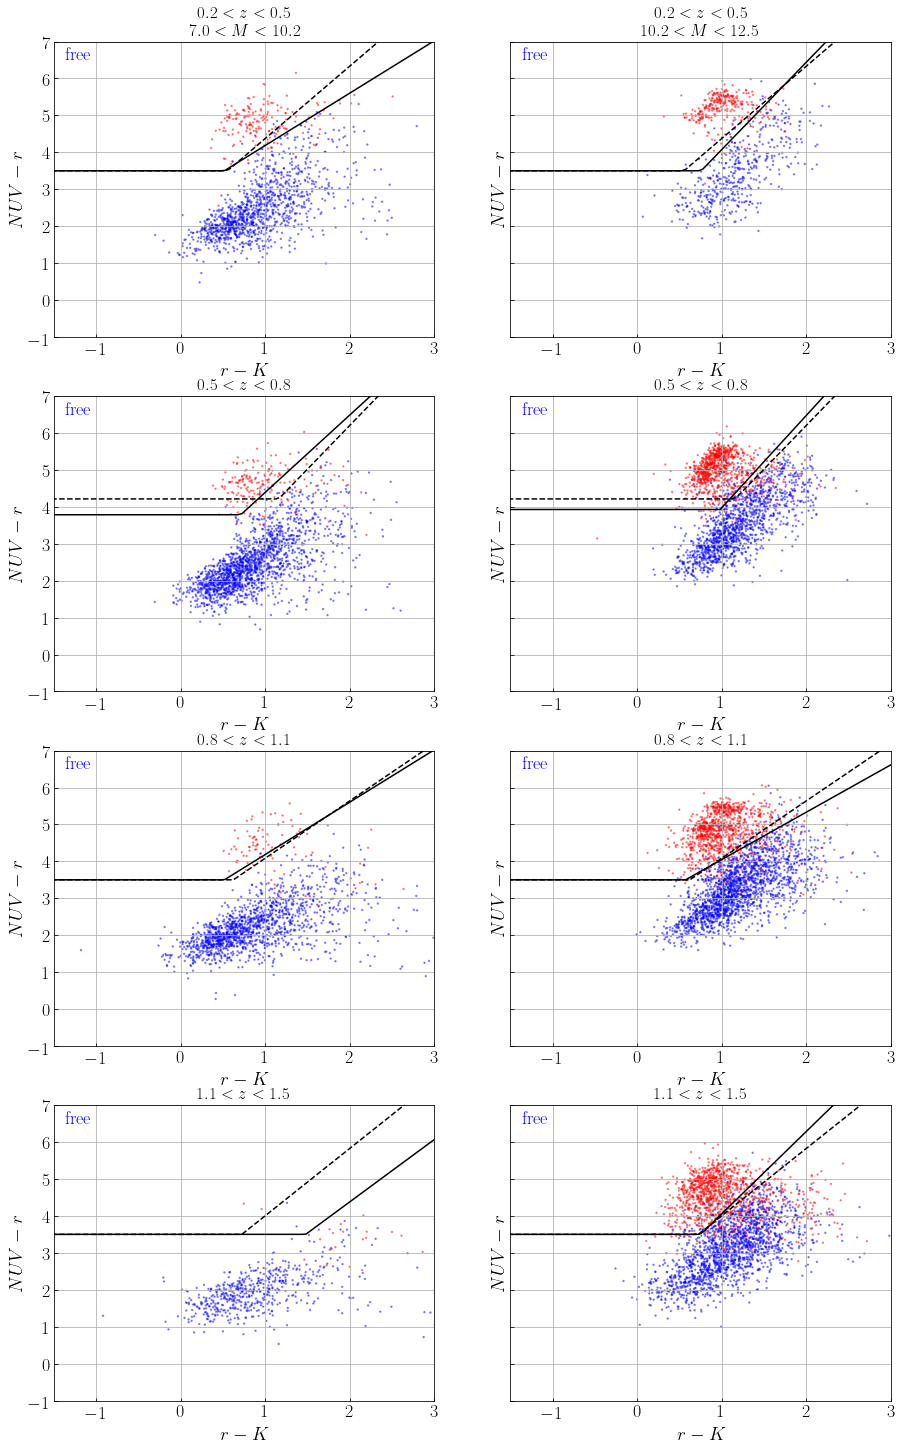

In [171]:
diagram_type = 'NUVrK'
phot_config = 'nonir'
fit_type='free'

fc_list_overall = [] # contatnimate fraction
fm_list_overall = [] # missed fraction
fc_list_massive = [] # contatnimate fraction
fm_list_massive = [] # missed fraction

mass_cut = 10.0
mass_lows = [8.0,mass_cut]
mass_highs = [mass_cut,12.5]
# catalog name
cat_name = cat_output_no_nir_mass_name
cat_output_c20added = Table.read(cat_name.replace('.fits','c20added.fits'))

fig, axs = plt.subplots(4, 2, figsize = (15, 25), sharey=True)
for z_idx,zmin in enumerate(z_mins):
    for mass_idx,mass_low in enumerate(mass_lows):
        cat_output_c20added_z = cat_output_c20added[(cat_output_c20added['Z_ML']>z_mins[z_idx]) & (cat_output_c20added['Z_ML']<z_maxs[z_idx])]
        
        # COSMOS consistent photoz objects only           
        flag_photoz = (cat_output_c20added_z['flag_photoz']==1)
        flag_optical = cat_output_c20added_z['flag_optical'] 
        flag_irac = cat_output_c20added_z['flag_irac'] 
        cond_filters = (flag_optical>2) & (flag_irac>=1)
        cat_output_c20added_z = cat_output_c20added_z[flag_photoz & cond_filters]
        cat_zmass = cat_output_c20added_z[cat_output_c20added_z['MASS_MED_massrun']>mass_lows[mass_idx]]
        cat_zmass = cat_zmass[cat_zmass['MASS_MED_massrun']<mass_highs[mass_idx]]
        
        print(z_mins[z_idx],z_maxs[z_idx],mass_lows[mass_idx],mass_highs[mass_idx],len(cat_zmass[cat_zmass['CLASS']==1]),len(cat_zmass[cat_zmass['CLASS']==0]))
        
        # plot data points
        if diagram_type == 'NUVrK':
            im = axs[z_idx][mass_idx].scatter(cat_zmass['MAG_ABS_r']-cat_zmass['MAG_ABS_Ks'], 
                                       cat_zmass['MAG_ABS_NUV']-cat_zmass['MAG_ABS_r'],
                                       s=2,c=cat_zmass['CLASS'],alpha=0.4,cmap='bwr_r',vmin=0,vmax=1)
            axs[z_idx][mass_idx].set_xlabel(r'$r-K$',fontsize=19)
        elif diagram_type == 'NUVrJ':
            im = axs[z_idx][mass_idx].scatter(cat_zmass['MAG_ABS_r']-cat_zmass['MAG_ABS_J'], 
                                       cat_zmass['MAG_ABS_NUV']-cat_zmass['MAG_ABS_r'],
                                       s=2,c=cat_zmass['CLASS'],alpha=0.4,cmap='bwr_r',vmin=0,vmax=1)
            axs[z_idx][mass_idx].set_xlabel(r'$r-J$',fontsize=19)
        
        # NUVrK selection box
        best_box = np.load('best_select_box_lepharecheck_'+diagram_type+'_'+phot_config+'_'+fit_type+'_'+str(mass_lows[mass_idx])+'_'+str(mass_highs[mass_idx])+'.npy')[z_idx]
        rk_draw = np.linspace(-2,3,100)
        nuv_draw_mid = gv_boundary_2(rk_draw,best_box[0],best_box[1],best_box[2])
        axs[z_idx][mass_idx].plot(rk_draw, nuv_draw_mid, color='k')
        
        best_box = np.load('best_select_box_lepharecheck_'+diagram_type+'_'+phot_config+'_'+fit_type+'.npy')[z_idx]
        rk_draw = np.linspace(-2,3,100)
        nuv_draw_mid = gv_boundary_2(rk_draw,best_box[0],best_box[1],best_box[2])
        axs[z_idx][mass_idx].plot(rk_draw, nuv_draw_mid, color='k',linestyle='--')
        
        axs[z_idx][mass_idx].set_ylabel(r'$NUV-r$',fontsize=19)
        axs[z_idx][mass_idx].set_xlim([-1.5,3])
        axs[z_idx][mass_idx].set_ylim([-1,7])
        axs[z_idx][mass_idx].grid()
        if z_idx == 0:
            axs[z_idx][mass_idx].set_title('$'+str(z_mins[z_idx])+'<z<'+str(z_maxs[z_idx])+'$\n'+'$'+str(mass_lows[mass_idx])+'<M<'+str(mass_highs[mass_idx])+'$' ,fontsize=17)
        else:
            axs[z_idx][mass_idx].set_title('$'+str(z_mins[z_idx])+'<z<'+str(z_maxs[z_idx])+'$',fontsize=17)
        axs[z_idx][mass_idx].annotate(fit_type.replace('_',' '),color='b',xy=([0.03,0.94]),xycoords='axes fraction',fontsize=18)
        
        # SVM class results
    #     with open('pickle_svm_'+phot_config+'_'+str(z_mins[z_idx])+'_'+str(z_maxs[z_idx])+'.pkl', 'rb') as file:
    #         clf_load = pickle.load(file)
            
    #     xx, yy = make_meshgrid(np.linspace(-1,3,100), np.linspace(-1,7,100))
    #     plot_contours(axs[row][z_idx], clf_load, xx, yy, cmap=plt.cm.coolwarm_r)
            
        #### contingency table / confusion matrix (inset plot 2) ######
        # q=P sf=N
        # cat = cat_zmass
        # cat_sf = cat[cat['CLASS']==1]
        # cat_q = cat[cat['CLASS']==0]
        # if diagram_type == 'NUVrK':
        #     rk_sf = np.array(cat_sf['MAG_ABS_r'] - cat_sf['MAG_ABS_Ks'])
        #     rk_q = np.array(cat_q['MAG_ABS_r'] - cat_q['MAG_ABS_Ks']) 
        #     delta_gv_sf = cat_sf['MAG_ABS_NUV'] - cat_sf['MAG_ABS_r']-gv_boundary_2(rk_sf,best_box[0],best_box[1],best_box[2])
        #     delta_gv_q = cat_q['MAG_ABS_NUV'] - cat_q['MAG_ABS_r']-gv_boundary_2(rk_q,best_box[0],best_box[1],best_box[2])
        # elif diagram_type == 'NUVrJ':
        #     rj_sf = np.array(cat_sf['MAG_ABS_r'] - cat_sf['MAG_ABS_J'])
        #     rj_q = np.array(cat_q['MAG_ABS_r'] - cat_q['MAG_ABS_J']) 
        #     delta_gv_sf = cat_sf['MAG_ABS_NUV'] - cat_sf['MAG_ABS_r']-gv_boundary_2(rj_sf,best_box[0],best_box[1],best_box[2])
        #     delta_gv_q = cat_q['MAG_ABS_NUV'] - cat_q['MAG_ABS_r']-gv_boundary_2(rj_q,best_box[0],best_box[1],best_box[2])
        
        # sf_sf = len(cat_sf[delta_gv_sf<0])  # TN
        # q_q = len(cat_q[delta_gv_q>0])      # TP
        # sf_q = len(cat_q[delta_gv_q<0])     # FP
        # q_sf = len(cat_sf[delta_gv_sf>0])   # FN
        # fc = 0#sf_q/(q_q+sf_q)
        # fm = 0#q_sf/(q_q+q_sf)
        # if selection == 'massive':
        #     fc_list_massive.append(fc)
        #     fm_list_massive.append(fm)
        # else:
        #     fc_list_overall.append(fc)
        #     fm_list_overall.append(fm)
        
        # inset table
        # axs[z_idx][mass_idx].annotate('sfc',xy=([0.08,0.24]),xycoords='axes fraction',fontsize=15)
        # axs[z_idx][mass_idx].annotate('qc',xy=([0.19,0.24]),xycoords='axes fraction',fontsize=15)
        # axs[z_idx][mass_idx].annotate('sf',xy=([0.03,0.17]),xycoords='axes fraction',fontsize=15)
        # axs[z_idx][mass_idx].annotate('q',xy=([0.03,0.1]),xycoords='axes fraction',fontsize=15)
        # ax_insert2 = axs[z_idx][mass_idx].inset_axes([0.08, 0.07, 0.2, 0.15])
        # ax_insert2.annotate(str(sf_sf),xy=([-0.9,0.1]),fontsize=14)
        # ax_insert2.annotate(str(sf_q),xy=([0.1,0.1]),fontsize=14)
        # ax_insert2.annotate(str(q_sf),xy=([-0.9,-0.9]),fontsize=14)
        # ax_insert2.annotate(str(q_q),xy=([0.1,-0.9]),fontsize=14)
        # ax_insert2.axvline(ymin=-1,ymax=1,x=0,color='k',linewidth=1)
        # ax_insert2.axhline(xmin=-1,xmax=1,y=0,color='k',linewidth=1)
        # ax_insert2.set_xlim([-1,1])
        # ax_insert2.set_ylim([-1,1])
        # ax_insert2.set_yticklabels([])
        # ax_insert2.set_xticklabels([])

##### write SF/Q flag to catalog

In [16]:
# sfq_info in catalog
# keynames: sfq_nuvrk_myrun_[...]



prefix = 'pcat_extinc_'
cat_type = 'all' # all or central_cosmos

if prefix == 'v9pcat_':
    z_keyname = 'Z_COM'
if prefix == 'pcat_' or prefix == 'pcat_extinc_':
    z_keyname = 'Z_COMBINE'
else:
    z_keyname = 'Z_ML'
    
if cat_type == 'all':
    cat_names = ['COSMOS_deep','DEEP_deep','ELAIS_deep']
elif cat_type == 'central_cosmos':
    cat_names = ['COSMOS_deep']
    
# phot_configs = ['nonirirac','nonir','noirac','allphot']
phot_configs = ['nonir']

# sfq_methods = ['old','free','fix_slope','evolving']
sfq_methods = ['free']
sfq_nuvrj_methods = ['free']

mass_split = 'split' # '' or 'split'
mass_cut = 10.0
mass_lows = [8.0,mass_cut]
mass_highs = [mass_cut,12.5]
    
for cat_name in cat_names:
    for phot_config in phot_configs:
        if cat_type == 'all': # all or central_cosmos
            cat_full_name = graham_output_dir+prefix+cat_name+'_cat_out_nomaglimit_'+phot_config+'_il_nz_prior_formass.fits'  # all fields     
        elif cat_type == 'central_cosmos' and 'pcat' not in prefix:
            cat_full_name = graham_output_dir+'cat_out_08squdeg_'+phot_config+'_il_nz_prior_nolimit_formass.fits' # central cosmos
        elif cat_type == 'central_cosmos' and 'pcat' in prefix:
            cat_full_name = graham_output_dir+'pcat_cat_out_08squdeg_'+phot_config+'_il_nz_prior_nolimit_formass.fits' # pcat central cosmos
            
        cat = Table.read(cat_full_name)
        arr = cat.keys()
        matches = [match for match in arr if "MAG_APER" in match]
        cat.remove_columns(matches)
        print(cat_full_name)
        
        #nuvrk
        diagram_type = 'NUVrK'
        for sfq_fit_type in sfq_methods:
            print(cat_name, phot_config, sfq_fit_type)
            sfq_nuvrk = []
            for i in tqdm(range(len(cat))):
                gal = cat[i]
                
                # load selection box
                if mass_split == 'split' and sfq_fit_type != 'old':
                    selected = False
                    for mass_idx in range(len(mass_lows)):
                        if gal['MASS_MED_massrun']>mass_lows[mass_idx] and gal['MASS_MED_massrun']<mass_highs[mass_idx]:
                            best_boxes_nuvrk = np.load('best_select_box_lepharecheck_'+diagram_type+'_'+phot_config+'_'+sfq_fit_type+'_'+str(mass_low)+'_'+str(mass_high)+'.npy')
                            selected = True
                            continue
                            
                    if not selected:
                        print(gal['MASS_MED_massrun'])
                        best_boxes_nuvrk = np.load('best_select_box_lepharecheck_'+diagram_type+'_'+phot_config+'_'+sfq_fit_type+'.npy')
                else:
                    best_boxes_nuvrk = np.load('best_select_box_lepharecheck_'+diagram_type+'_'+phot_config+'_'+sfq_fit_type+'.npy')
                    
                if abs(gal['MAG_ABS_r']) < 50. and abs(gal['MAG_ABS_Ks'])< 50. and gal['MAG_ABS_NUV']< 50. and abs(gal['MAG_ABS_r'])< 50.:
                    rk = gal['MAG_ABS_r'] - gal['MAG_ABS_Ks']
                    nuvr = gal['MAG_ABS_NUV'] - gal['MAG_ABS_r']
                    if gal[z_keyname]>0.2 and gal[z_keyname]<0.5:
                        delta_gv_nuvrk = nuvr - gv_boundary_2(rk,best_boxes_nuvrk[0][0],best_boxes_nuvrk[0][1],best_boxes_nuvrk[0][2])
                        if delta_gv_nuvrk<0:
                            sfq_nuvrk.append(1.)
                        else:
                            sfq_nuvrk.append(0.)
                    elif gal[z_keyname]>0.5 and gal[z_keyname]<0.8:
                        delta_gv_nuvrk = nuvr - gv_boundary_2(rk,best_boxes_nuvrk[1][0],best_boxes_nuvrk[1][1],best_boxes_nuvrk[1][2])
                        if delta_gv_nuvrk<0:
                            sfq_nuvrk.append(1.)
                        else:
                            sfq_nuvrk.append(0.)
                    elif gal[z_keyname]>0.8 and gal[z_keyname]<1.1:
                        delta_gv_nuvrk = nuvr - gv_boundary_2(rk,best_boxes_nuvrk[2][0],best_boxes_nuvrk[2][1],best_boxes_nuvrk[2][2])
                        if delta_gv_nuvrk<0:
                            sfq_nuvrk.append(1.)
                        else:
                            sfq_nuvrk.append(0.)
                    elif gal[z_keyname]>1.1 and gal[z_keyname]<1.5:
                        delta_gv_nuvrk = nuvr - gv_boundary_2(rk,best_boxes_nuvrk[3][0],best_boxes_nuvrk[3][1],best_boxes_nuvrk[3][2])
                        if delta_gv_nuvrk<0:
                            sfq_nuvrk.append(1.)
                        else:
                            sfq_nuvrk.append(0.)
                    else:
                        sfq_nuvrk.append(-99.)
                else:
                    sfq_nuvrk.append(99.)
                
            sfq_col_nuvrk = Column(name='sfq_nuvrk_myrun_'+sfq_fit_type,data=sfq_nuvrk)  # 1=sf, 0=q
            if 'sfq_nuvrk_myrun'+sfq_fit_type in cat.keys():
                cat.remove_column('sfq_nuvrk_myrun'+sfq_fit_type)
            cat.add_column(sfq_col_nuvrk)
            
        # nuvrj 
#         diagram_type = 'NUVrJ'
#         for sfq_fit_type in sfq_nuvrj_methods:
#             print(cat_name, phot_config, sfq_fit_type)
#             sfq_nuvrj = []
#             for i in tqdm(range(len(cat))):
#                 gal = cat[i]
                
#                 # load selection box
#                 if mass_split == 'split' and sfq_fit_type != 'old':
#                     selected = False
#                     for mass_idx in range(len(mass_lows)):
#                         if gal['MASS_MED_massrun']>mass_lows[mass_idx] and gal['MASS_MED_massrun']<mass_highs[mass_idx]:
#                             best_boxes_nuvrj = np.load('best_select_box_lepharecheck_'+diagram_type+'_'+phot_config+'_'+sfq_fit_type+'_'+str(mass_low)+'_'+str(mass_high)+'.npy')
#                             selected = True
#                             continue
                            
#                     if not selected:
#                         print(gal['MASS_MED_massrun'])
#                         best_boxes_nuvrj = np.load('best_select_box_lepharecheck_'+diagram_type+'_'+phot_config+'_'+sfq_fit_type+'.npy')
#                 else:
#                     best_boxes_nuvrj = np.load('best_select_box_lepharecheck_'+diagram_type+'_'+phot_config+'_'+sfq_fit_type+'.npy')
                    
#                 if abs(gal['MAG_ABS_r']) < 50. and abs(gal['MAG_ABS_J'])< 50. and gal['MAG_ABS_NUV']< 50. and abs(gal['MAG_ABS_r'])< 50.:
#                     rj = gal['MAG_ABS_r'] - gal['MAG_ABS_J']
#                     nuvr = gal['MAG_ABS_NUV'] - gal['MAG_ABS_r']
#                     if gal[z_keyname]>0.2 and gal[z_keyname]<0.5:
#                         delta_gv_nuvrj = nuvr - gv_boundary_2(rk,best_boxes_nuvrj[0][0],best_boxes_nuvrj[0][1],best_boxes_nuvrj[0][2])
#                         if delta_gv_nuvrj<0:
#                             sfq_nuvrj.append(1.)
#                         else:
#                             sfq_nuvrj.append(0.)
#                     elif gal[z_keyname]>0.5 and gal[z_keyname]<0.8:
#                         delta_gv_nuvrj = nuvr - gv_boundary_2(rj,best_boxes_nuvrj[1][0],best_boxes_nuvrj[1][1],best_boxes_nuvrj[1][2])
#                         if delta_gv_nuvrj<0:
#                             sfq_nuvrj.append(1.)
#                         else:
#                             sfq_nuvrj.append(0.)
#                     elif gal[z_keyname]>0.8 and gal[z_keyname]<1.1:
#                         delta_gv_nuvrj = nuvr - gv_boundary_2(rj,best_boxes_nuvrj[2][0],best_boxes_nuvrj[2][1],best_boxes_nuvrj[2][2])
#                         if delta_gv_nuvrj<0:
#                             sfq_nuvrj.append(1.)
#                         else:
#                             sfq_nuvrj.append(0.)
#                     elif gal[z_keyname]>1.1 and gal[z_keyname]<1.5:
#                         delta_gv_nuvrj = nuvr - gv_boundary_2(rj,best_boxes_nuvrj[3][0],best_boxes_nuvrj[3][1],best_boxes_nuvrj[3][2])
#                         if delta_gv_nuvrj<0:
#                             sfq_nuvrj.append(1.)
#                         else:
#                             sfq_nuvrj.append(0.)
#                     else:
#                         sfq_nuvrj.append(-99.)
#                 else:
#                     sfq_nuvrj.append(99.)
                
#             sfq_col_nuvrj = Column(name='sfq_nuvrj_myrun_'+sfq_fit_type,data=sfq_nuvrk)  # 1=sf, 0=q
#             if 'sfq_nuvrj_myrun'+sfq_fit_type in cat.keys():
#                 cat.remove_column('sfq_nuvrj_myrun'+sfq_fit_type)
#             cat.add_column(sfq_col_nuvrj)
            
        # add sfProb (SVM class) column
#         with open('pickle_svm_'+phot_config+'_'+diagram_type+'_'+str(z_mins[z_idx])+'_'+str(z_maxs[z_idx])+'.pkl', 'rb') as file:
#             clf_load = pickle.load(file)
#         rk = np.array(cat['MAG_ABS_r'] - cat['MAG_ABS_Ks']).tolist()
#         nuvr = np.array(cat['MAG_ABS_NUV']   - cat['MAG_ABS_r']).tolist()
#         sfProb_data = clf_load.predict_proba(np.c_[rk,nuvr])[:,0]
        
#         sfProb_col = Column(name='sfProb',data=sfProb_data)
#         cat.add_column(sfProb_col)
#         print('sf Prob written')
        
        # write catalog
        cat.write(cat_full_name.replace('.fits','_sfq_added.fits'),overwrite=True)
        

  0%|          | 0/1537705 [00:00<?, ?it/s]

/Users/lejay/research/lephare_dev/my_code/graham_output_cats/pcat_extinc_COSMOS_deep_cat_out_nomaglimit_nonir_il_nz_prior_formass.fits
COSMOS_deep nonir free


FileNotFoundError: [Errno 2] No such file or directory: 'best_select_box_lepharecheck_NUVrK_nonir_free_10.0_12.5.npy'

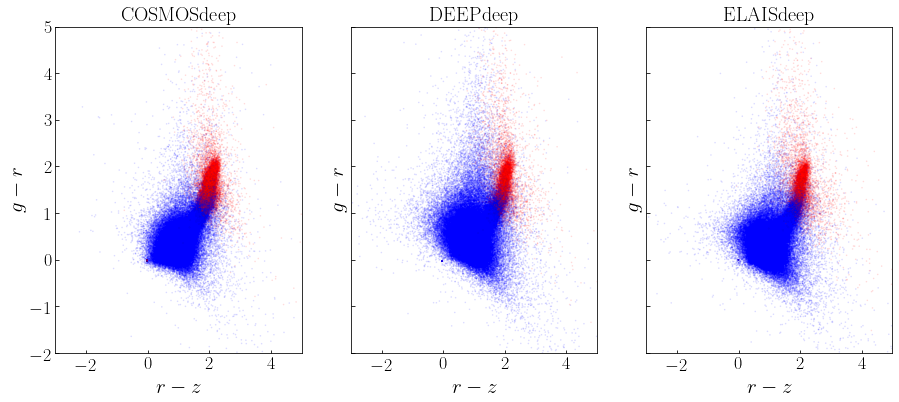

In [95]:
# galaxies within 0.8<z<1.1

z_mins = np.array([0.2, 0.5, 0.8, 1.1])
z_maxs = np.array([0.5, 0.8, 1.1, 1.5])
phot_config = 'nonir'
selection_type = 'NUVrK'
fit_type='free'

fig, axs = plt.subplots(1, 3, figsize = (15, 6), sharey=True)
for cat_idx,cat_name in enumerate(['COSMOS_deep','DEEP_deep','ELAIS_deep']):
    cat_name_full = graham_output_dir+cat_name+'_cat_out_nomaglimit_'+phot_config+'_il_nz_prior_formass_sfq_added.fits'
    cat_output = Table.read(cat_name_full)
    
    cat_output = cat_output[cat_output['MASK'] == 0]  # unmasked
    cat_output = cat_output[cat_output['OBJ_TYPE'] == 0]  # galaxies
    cat_output_z = cat_output[(cat_output['Z_ML']>0.8) & (cat_output['Z_ML']<1.1)]
    
    im = axs[cat_idx].scatter(cat_output_z['r']-cat_output_z['z'], 
                                       cat_output_z['g']-cat_output_z['r'],
                                       s=0.5,c=cat_output_z['sfq_nuvrk_myrun_free'],alpha=0.1,cmap='bwr_r',vmin=0,vmax=1)
    axs[cat_idx].set_xlabel(r'$r-z$',fontsize=21)
    axs[cat_idx].set_ylabel(r'$g-r$',fontsize=21)
    axs[cat_idx].set_xlim([-3,5])
    axs[cat_idx].set_ylim([-2,5])
    axs[cat_idx].set_title(cat_name.replace('_',''),fontsize=20)

Text(0.5, 0.98, 'All Galaxies')

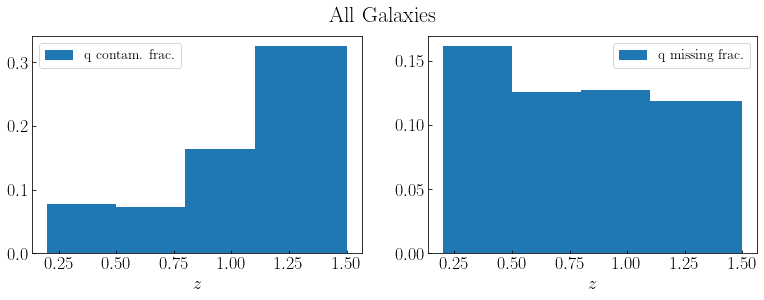

In [203]:
fig, axs = plt.subplots(1, 2, figsize = (13, 4))

axs[0].bar(zmin_list,fc_list_overall,width=zmax_list-zmin_list,label='q contam. frac.',align='edge')
axs[1].bar(zmin_list,fm_list_overall,width=zmax_list-zmin_list,label='q missing frac.',align='edge')
axs[0].set_xlabel('$z$',fontsize=18)
axs[1].set_xlabel('$z$',fontsize=18)
axs[0].legend(fontsize=14)
axs[1].legend(fontsize=14)

plt.suptitle('All Galaxies',fontsize=22)

Text(0.5, 0.98, 'Massive Galaxies')

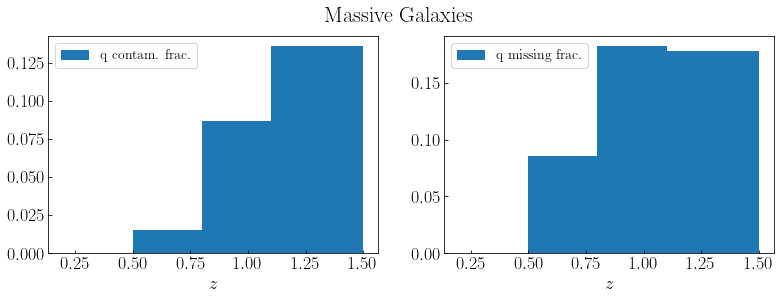

In [204]:
fig, axs = plt.subplots(1, 2, figsize = (13, 4))

axs[0].bar(zmin_list,fc_list_massive,width=zmax_list-zmin_list,label='q contam. frac.',align='edge')
axs[1].bar(zmin_list,fm_list_massive,width=zmax_list-zmin_list,label='q missing frac.',align='edge')
axs[0].set_xlabel('$z$',fontsize=18)
axs[1].set_xlabel('$z$',fontsize=18)
axs[0].legend(fontsize=14)
axs[1].legend(fontsize=14)

plt.suptitle('Massive Galaxies',fontsize=22)